In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel'
plt_dir = gwfm_dir+'/Levee_setback/figures/'
gwfm_dir


'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel'

## Pick model type to review
RIV is the simple model with only SS assumptions about Blodgett Dam depth and area
LAK is the complex model with interactive flow between the stream and Blodgett Dam

In [3]:
# model_type = 'RIV'
# model_type = 'LAK'

In [4]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/levee_setback/streamflow/'

runs = ['setback_streamflow','historical_streamflow']
runs

['setback_streamflow', 'historical_streamflow']

In [5]:
# model_ws =loadpth+'/actual_200cfs'

# i=0
# os.listdir(loadpth+runs[i])
# glob.glob(loadpth+runs[i]+'/*.nam')[0]
# model_ws = loadpth+runs[i]
# model_nam = 'setback_streamflow'
model_nam = 'historical_streamflow'

model_ws = loadpth+model_nam
model_type = 'LAK'

In [6]:

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')
# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005.exe', version='mf2005')

In [7]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

In [8]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
# cbc = model_ws+'/MF.cbc'
strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp

# Water budget processing

In [30]:
def zone_clean_tr(cbc,zon,  kstpkper):
    zb = flopy.utils.ZoneBudget(cbc, zon)
    zb_df = zb.get_dataframes()
    # # ungroup by timestep
    zb_df = zb_df.reset_index()
    names = zb_df.name.unique()
    zb_df = zb_df.pivot(index = 'totim', columns = 'name',values = 'ZONE_1')

    # # multiply by -1 to have pulled out of water balance on plot
    zb_df.loc[:,zb_df.columns.str.contains('TO_')] *= -1
    zb_df['delSTORAGE'] = zb_df.TO_STORAGE - zb_df.FROM_STORAGE
    # create date index
    zb_df['Date'] = pd.to_datetime(m.start_datetime)+zb_df.index.values.astype('timedelta64[D]')- np.ones(1).astype('timedelta64[D]')
    zb_df = zb_df.set_index('Date')
    return(zb_df)

In [31]:
# shapefile rectangle of the area surrounding the Dam within about 5 cells
zon_dam_gpd = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/zon_bud_extent/zon_bud_extent.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

zon_cells = gpd.sjoin(grid_p,zon_dam_gpd,how='right',op='within')
# zon_cells = gpd.sjoin(grid_p,zon_dam_gpd) #includes more cells, including with high conductance

# filter zone budget for Blodgett Dam to just within 5 cells or so of the Dam
# zon_dam = np.zeros((m.dis.nrow,m.dis.ncol),dtype=int)
zon_dam = np.zeros((grid_p.row.max(),grid_p.column.max()),dtype=int)

zon_dam[zon_cells.row-1,zon_cells.column-1]=1

zon_mod = np.ones((grid_p.row.max(),grid_p.column.max()),dtype=int)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
dam_cols = ['FROM_RECHARGE','FROM_STREAM_LEAKAGE', 'TO_WELLS',
            'TO_STREAM_LEAKAGE','FROM_ZONE_0','TO_ZONE_0']
all_cols = ['FROM_CONSTANT_HEAD', 'FROM_RECHARGE','FROM_HEAD_DEP_BOUNDS','FROM_STREAM_LEAKAGE',
              'TO_CONSTANT_HEAD','TO_HEAD_DEP_BOUNDS', 'TO_WELLS','TO_STREAM_LEAKAGE']
if model_nam =='setback_streamflow':
    extra_cols = ['FROM_LAKE_SEEPAGE','TO_LAKE_SEEPAGE']
    dam_cols = np.append(dam_cols,extra_cols)
    all_cols = np.append(all_cols,extra_cols)
# elif model_type == 'RIV':
#     extra_cols = ['FROM_RIVER_LEAKAGE','TO_RIVER_LEAKAGE']



zb_dam_all = pd.DataFrame(columns = dam_cols)
zb_dam_all.index.name = 'name'
zb_mod_all = pd.DataFrame(columns = all_cols)
zb_mod_all.index.name = 'name'

In [33]:
# load cbb file from any model scneario to get listing of kstpkper
cbc = model_ws+'/MF.cbc'
# zb = flopy.utils.ZoneBudget(cbc, zon_dam)
# kstpkper = zb.kstpkper



In [34]:
zb_dam_df = zone_clean_tr(cbc,zon_dam,spd_stp)
zb_mod_df = zone_clean_tr(cbc,zon_mod,spd_stp)


In [35]:
zb_dam_all = zb_dam_df.loc[:,dam_cols]
zb_mod_all = zb_mod_df.loc[:,all_cols]

In [36]:
# for i in np.arange(0,len(runs)):
#     cbc = loadpth+runs[i]+'/MF.cbc'

#     # cbc = m.model_ws+'/MF.cbc'
#     # # using 0 indicates not in zone
#     # zon = m.bas6.ibound[0,:,:]

#     # # Create a ZoneBudget object and get the budget record array

#     zb_df = zone_clean_tr(cbc,zon_dam, kstpkper)
#     final_cols = zb_df.columns.join(dam_cols,how='inner')
#     zb_dam_all = zb_dam_all.append(zb_df.loc[:,final_cols])

#     zb_df = zone_clean_tr(cbc,zon_mod, kstpkper)
#     final_cols = zb_df.columns.join(all_cols,how='inner')
#     zb_mod_all = zb_mod_all.append(zb_df.loc[:,final_cols])

In [37]:
zon_color_dict = pd.read_csv(plt_dir+'mf_wb_color_dict.csv',header=0, index_col='flux',skiprows=1).color.to_dict()
zon_name_dict = pd.read_csv(plt_dir+'mf_wb_color_dict.csv',header=0, index_col='flux',skiprows=1).name.to_dict()
m3_2_AF = (1/0.3048**3)*(1/43560)

## Local water budget

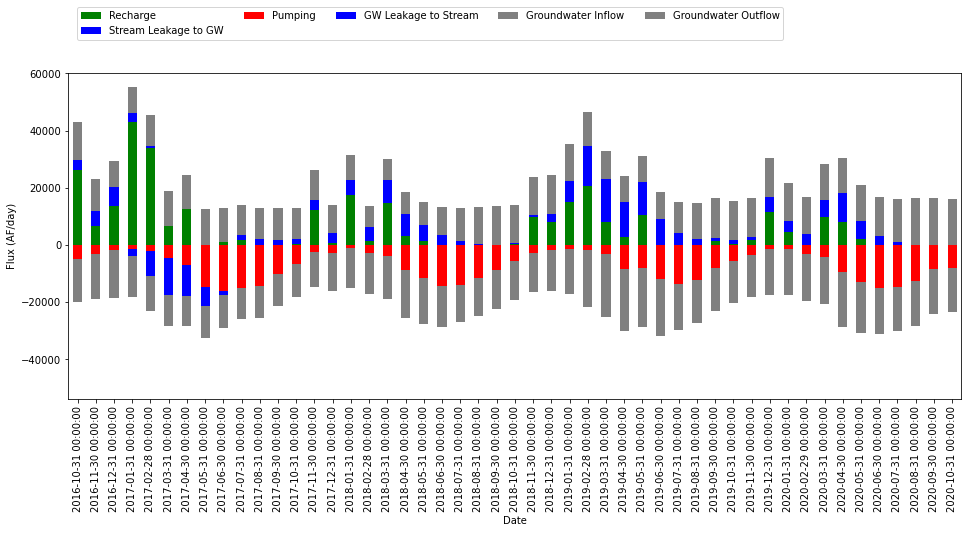

In [38]:
zb_dam_all_M = zb_dam_all.resample('M').mean()
fig, ax = plt.subplots(figsize=(16,6))


zb_dam_all_M.plot(y=dam_cols,
           kind='bar',ax=ax, stacked = True,legend=False,
               color=[zon_color_dict[x] for x in dam_cols], label = [zon_name_dict[x] for x in dam_cols])

stor_plt =  zb_dam_df.resample('M').mean().delSTORAGE
ax.plot(stor_plt.index.values, stor_plt.values)

plt.ylabel('Flux (AF/day)')
plt.legend(loc=(0.01,1.1),ncol=5)
plt.savefig('monthly_local_WB_'+model_nam+'.png', dpi=600)

In [39]:
# convert m3/day to AF/30 days
# zb_dam_all_AF = zb_dam_all*m3_2_AF

# fig, ax = plt.subplots(figsize=(16,6))
# zb_dam_all_AF.plot(y=dam_cols,
#            kind='bar',ax=ax, stacked = True,legend=False,
#                color=[zon_color_dict[x] for x in dam_cols], label = [zon_name_dict[x] for x in dam_cols])
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# plt.ylabel('Flux (AF/day)')
# plt.legend(loc=(0.01,1.1),ncol=5)


# plt.xlabel('Scenario')
# plt.savefig(plt_dir+'/dam_all_AF_day.png',dpi=600,bbox_inches='tight')


## Domain water budget

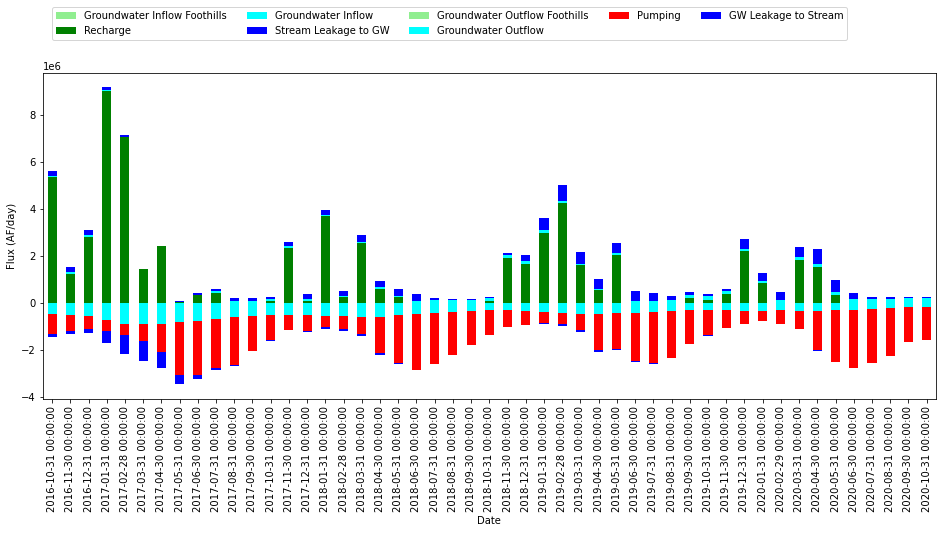

In [40]:
zb_mod_all_M = zb_mod_all.resample('M').mean()
fig, ax = plt.subplots(figsize=(16,6))

zb_mod_all_M.plot(y=all_cols,
           kind='bar',ax=ax, stacked = True,legend=False,
               color=[zon_color_dict[x] for x in all_cols], label = [zon_name_dict[x] for x in all_cols])
plt.ylabel('Flux (AF/day)')
plt.legend(loc=(0.01,1.1),ncol=5)
plt.savefig('monthly_domain_WB_'+model_nam+'.png', dpi=600)

In [272]:
# convert m3/day to AF/day
# zb_mod_all_AF = zb_mod_all*m3_2_AF

# fig, ax = plt.subplots(figsize=(16,6))
# zb_mod_all_AF.plot(y=all_cols,
#            kind='bar',ax=ax, stacked = True,
#                color=[zon_color_dict[x] for x in all_cols], label = [zon_name_dict[x] for x in all_cols])

# # clean up x axis so there are not as many dates
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# plt.legend(loc=(0.0,1.1),ncol=5)
# plt.ylabel('Flux (AF/day)')
# plt.title('Water Budget for Entire Domain')


# plt.savefig(plt_dir+'/domain_waterbudget_'+model_type+'_AF_day.png',dpi=600,bbox_inches='tight')

## Annual sum water budget

In [ ]:
def annual_WB(zb_annual,unit, zon):
    # if unit = AF convert units, else leave as m3
    if unit == 'AF':
        # ((1 ft/ 0.3048 m)^3) * (1 acre/43560 ft2)
        zb_annual = zb_annual/((0.3048**3) *43560)
    if zon == 'valley':
        cols = [ 'FROM_RECHARGE', 'FROM_ZONE_0', 'TO_ZONE_0', 'TO_WELLS']        
    elif zon == 'all':
        cols = ['FROM_CONSTANT_HEAD', 'FROM_GHB', 'FROM_RECHARGE', 'TO_CONSTANT_HEAD', 'TO_GHB', 'TO_WELLS']

    #fixes issues with line and bar plotting
    zb_annual.index = zb_annual.index.astype(str)
    
    fig, ax = plt.subplots(figsize=(16,6))
    # clean up x axis so there are not as many dates
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    zb_annual.plot(y=['dSTORAGE'],ax=ax, color = 'black')
    # define columns to plot
    
    # plot acre ft instead of meters
    zb_annual.plot(y= cols,
               kind='bar',ax=ax, stacked = True)
    plt.ylabel('Flux (ac-ft/year)')

    zb_annual.plot(y=['SUM_dSTORAGE'],ax=ax, secondary_y = True,rot=90)
    plt.xticks(rotation=90)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    plt.ylabel('Flux (ac-ft/year)')
    plt.xlabel('Datetime')
    plt.title('Water Budget for Butte Valley')
    plt.savefig(m.model_ws+'/Plots/annualsum_WB_'+zon+'_'+unit+'.png',dpi=300,bbox_inches = 'tight')
    zb_annual.to_csv(m.model_ws+'/Plots/annualsum_WB_'+zon+'_'+unit+'.csv')

In [ ]:
annual_WB(zb_annual118,unit = 'AF',zon='valley')
annual_WB(zb_annual,unit = 'AF',zon='all')

In [ ]:
def monthly_WB(zb_df,unit, zon, wy,name):
    plt_strt = pd.to_datetime(str(wy-1)+'-10-01')
    plt_end = pd.to_datetime(str(wy)+'-9-30')
    zb_plot = zb_df.loc[(zb_df.index>plt_strt)&(zb_df.index<plt_end)]
    zb_plot.index = zb_plot.index.astype(str)
    # if unit = AF convert units, else leave as m3
    if unit == 'AF':
        # ((1 ft/ 0.3048 m)^3) * (1 acre/43560 ft2)
        zb_plot = zb_plot/((0.3048**3) *43560)
    if zon == 'valley':
        cols = [ 'FROM_RECHARGE', 'FROM_ZONE_0', 'TO_ZONE_0', 'TO_WELLS']        
    elif zon == 'all':
        cols = ['FROM_CONSTANT_HEAD', 'FROM_GHB', 'FROM_RECHARGE', 'TO_CONSTANT_HEAD', 'TO_GHB', 'TO_WELLS']

    #fixes issues with line and bar plotting
    zb_plot.index = zb_plot.index.astype(str)
    
    fig, ax = plt.subplots(figsize=(16,6))
    # clean up x axis so there are not as many dates
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    zb_plot.plot(y=['dSTORAGE'],ax=ax, color = 'black')
    ax.hlines(y=0, xmin = -1, xmax = 100, color = 'black')

    # plot acre ft instead of meters
    zb_plot.plot(y= cols,
               kind='bar',ax=ax, stacked = True)
    plt.ylabel('Flux (ac-ft/month)')

    zb_plot.plot(y=['SUM_dSTORAGE'],ax=ax, secondary_y = True,rot=90)
    plt.xticks(rotation=90)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    plt.ylabel('Flux (ac-ft/month)')
    plt.xlabel('Datetime')
    plt.title('Water Budget for Butte Valley WY'+str(wy)+' - '+name+' Year' )
    plt.savefig(m.model_ws+'/Plots/'+name+'_'+str(wy)+'monthlyWB_'+zon+'_'+unit+'.png',dpi=300,bbox_inches = 'tight')

In [ ]:
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=1999,name='Wet')
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=2005,name='Avg')
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=2014,name='Dry')